# Classificação de Belignos E Malignos
##Importação das bibliotecas

Tumor é o nome dado ao crescimento rápido e imprevisto de células humanas e podem ser benignos ou malignos. Tumores malignos ocorrem quando esse processo de crescimento celular danifica outras células do corpo humano a ponto de se espalhar para outras partes do corpo (metástase).

Segundo o DATASUS "As neoplasias constituem a terceira causa de morte no Brasil, representando, em 1998, 14% dos óbitos informados. As estimativas para o ano 2001 indicam a ocorrência de aproximadamente 305 mil casos e 117 mil óbitos por tumores malignos".

O que mais atrapalha o tratamento e a cura dessa doença é o diagnóstico tardio, pois além de muitos sintomas não serem percebido logo que a doença surge, certos exames que podem diagnosticar esse problema podem não ser rápidos em identificar o tipo do tumor. Tendo em vista isso temos, então, um problema de classificação. Precisaremos identificar se o tumor é benigno ou maligno.

1) Número de identificação

2) Diagnóstico (1 = maligno, 0 = benigno)

3) raio (média das distâncias do centro aos pontos do perímetro)

4) textura (desvio padrão dos valores da escala de cinza)

5) perímetro

6) área

7) lisura (variação local nos comprimentos do raio)

8) compacidade (perímetro ^ 2 / área - 1,0)

9) concavidade (gravidade das partes côncavas do contorno)

10) pontos côncavos (número de partes côncavas do contorno)

11) simetria

12) dimensão fractal

Para cada features serão usadas a suas médias (mean), desvios-padrões (se) e "pior" ou maior (worst) para classificação.


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.metrics import (balanced_accuracy_score,
                             confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, RocCurveDisplay


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
df_cancer = pd.read_csv("cancer_classification.csv")
df_cancer.head(5)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,benign_0__mal_1
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


é possível analisar que o dataframe é dividido em 3 subconjuntos

1)**Mean**

2)**Error**

3)**Worst**

Para análise dos dados, vai ser necessário separar os dados nesses três subconjuntos

In [ ]:
df_cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

Visualização dos tipos das colunas

In [ ]:
pd.value_counts(df_cancer.dtypes)

<ipython-input-4-2f6bd990eb5f>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df_cancer.dtypes)


,count
float64,30
int64,1


Ao analisar as estatística dos dados, se torna uma tarefa difícil devido a grande quantidade de colunas para analisar.

In [ ]:
df_cancer.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,benign_0__mal_1
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


Visualização se há existência de valores vazios

Percebe-se que não existe valores vazios nas colunas

In [ ]:
df_cancer.isnull().sum()

,0
mean radius,0
mean texture,0
mean perimeter,0
mean area,0
mean smoothness,0
mean compactness,0
mean concavity,0
mean concave points,0
mean symmetry,0
mean fractal dimension,0


Apartir da análise da correlação das features com a variável de diagnóstico.É possível concluir que na grande maioria das features existe uma correlação negativa

Essa análise consiste analisar as features com uma determiada variável alvo, o intervalo dessa correlação é de [-1 a 1] no qual valores abaixo de *0* é considerado uma correlação negativa e acima de *1* é considerado uma correlação positiva

É notavel que na maioria das features existe uma correlação negativa com a variável alvo.A coluna *mean concave points* é umas features que se destaca com uma correlação negativa forte



In [ ]:
df_cancer.corr()['benign_0__mal_1'].sort_values(ascending=True)

,benign_0__mal_1
worst concave points,-0.793566
worst perimeter,-0.782914
mean concave points,-0.776614
worst radius,-0.776454
mean perimeter,-0.742636
worst area,-0.733825
mean radius,-0.730029
mean area,-0.708984
mean concavity,-0.696360
worst concavity,-0.659610


#  Análise e visualização dos dados
Podemos ver que a variável alvo está desbalanceada, pois existem mais diagnósticos Malignos (1) do que Belignos (0)

<ipython-input-8-f320f7b93e2c>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x =df_cancer['benign_0__mal_1'], palette ='Set2')


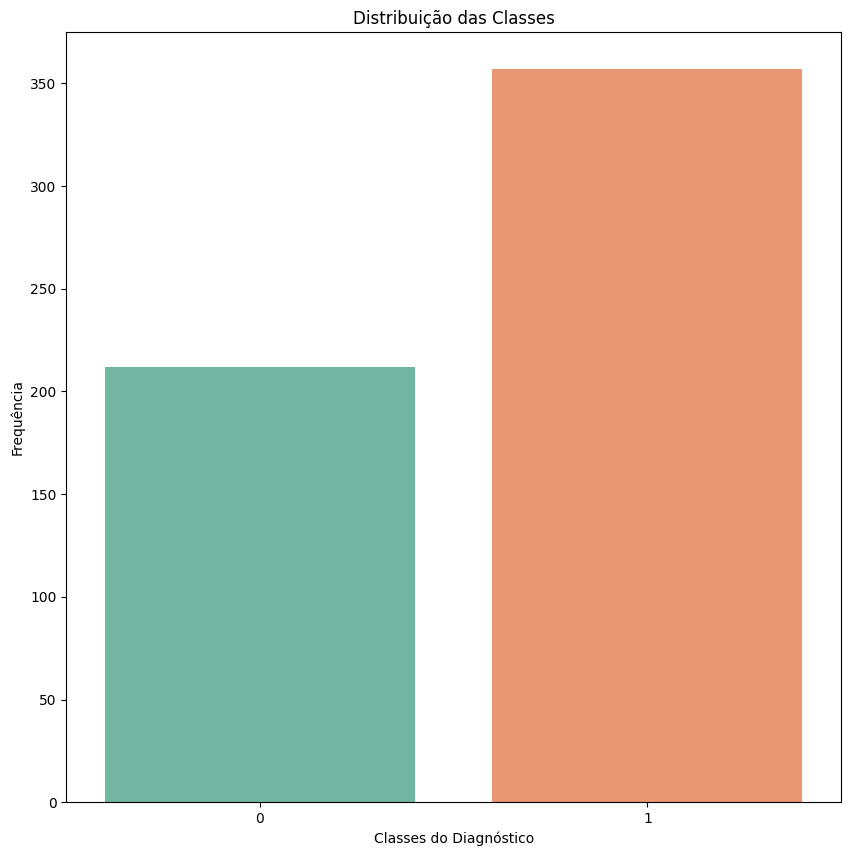

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(x =df_cancer['benign_0__mal_1'], palette ='Set2')
plt.xlabel("Classes do Diagnóstico")
plt.ylabel("Frequência")
plt.title("Distribuição das Classes")
plt.show()

A seguir iremos separar os dados em três subconjuntos em *Mean*, *Error*, *Worst*.Para isso, iremos usar o comando do *Pandas* que facilita a coleta dos dados apartir do índice da coluna

In [ ]:
df_cancer_mean = pd.concat([df_cancer.iloc[:, 0:10], df_cancer.iloc[:, 30]], axis=1)
df_cancer_error = pd.concat([df_cancer.iloc[:, 10:20], df_cancer.iloc[:, 30]], axis=1)
df_cancer_worst = df_cancer.iloc[:, 20:31]

In [ ]:
df_cancer_worst = df_cancer.iloc[:, 20:31]

#Análise  dos Dados
Para análise dos três subconjuntos iremos usar comandos da biblioteca *Seaborn*

1) *Boxplots* para análisar o conjunto *Mean*

2) *Swarmplot* para analisar o conjunto *Error*

3) *Kdeplot* para analisar o conjunto *Worst*

A importação dessas análises é fundamental para entender o comportamento dos tipos *Belignos* e *Malignos* entre os dados

##Análise dos valores médios com a variável alvo


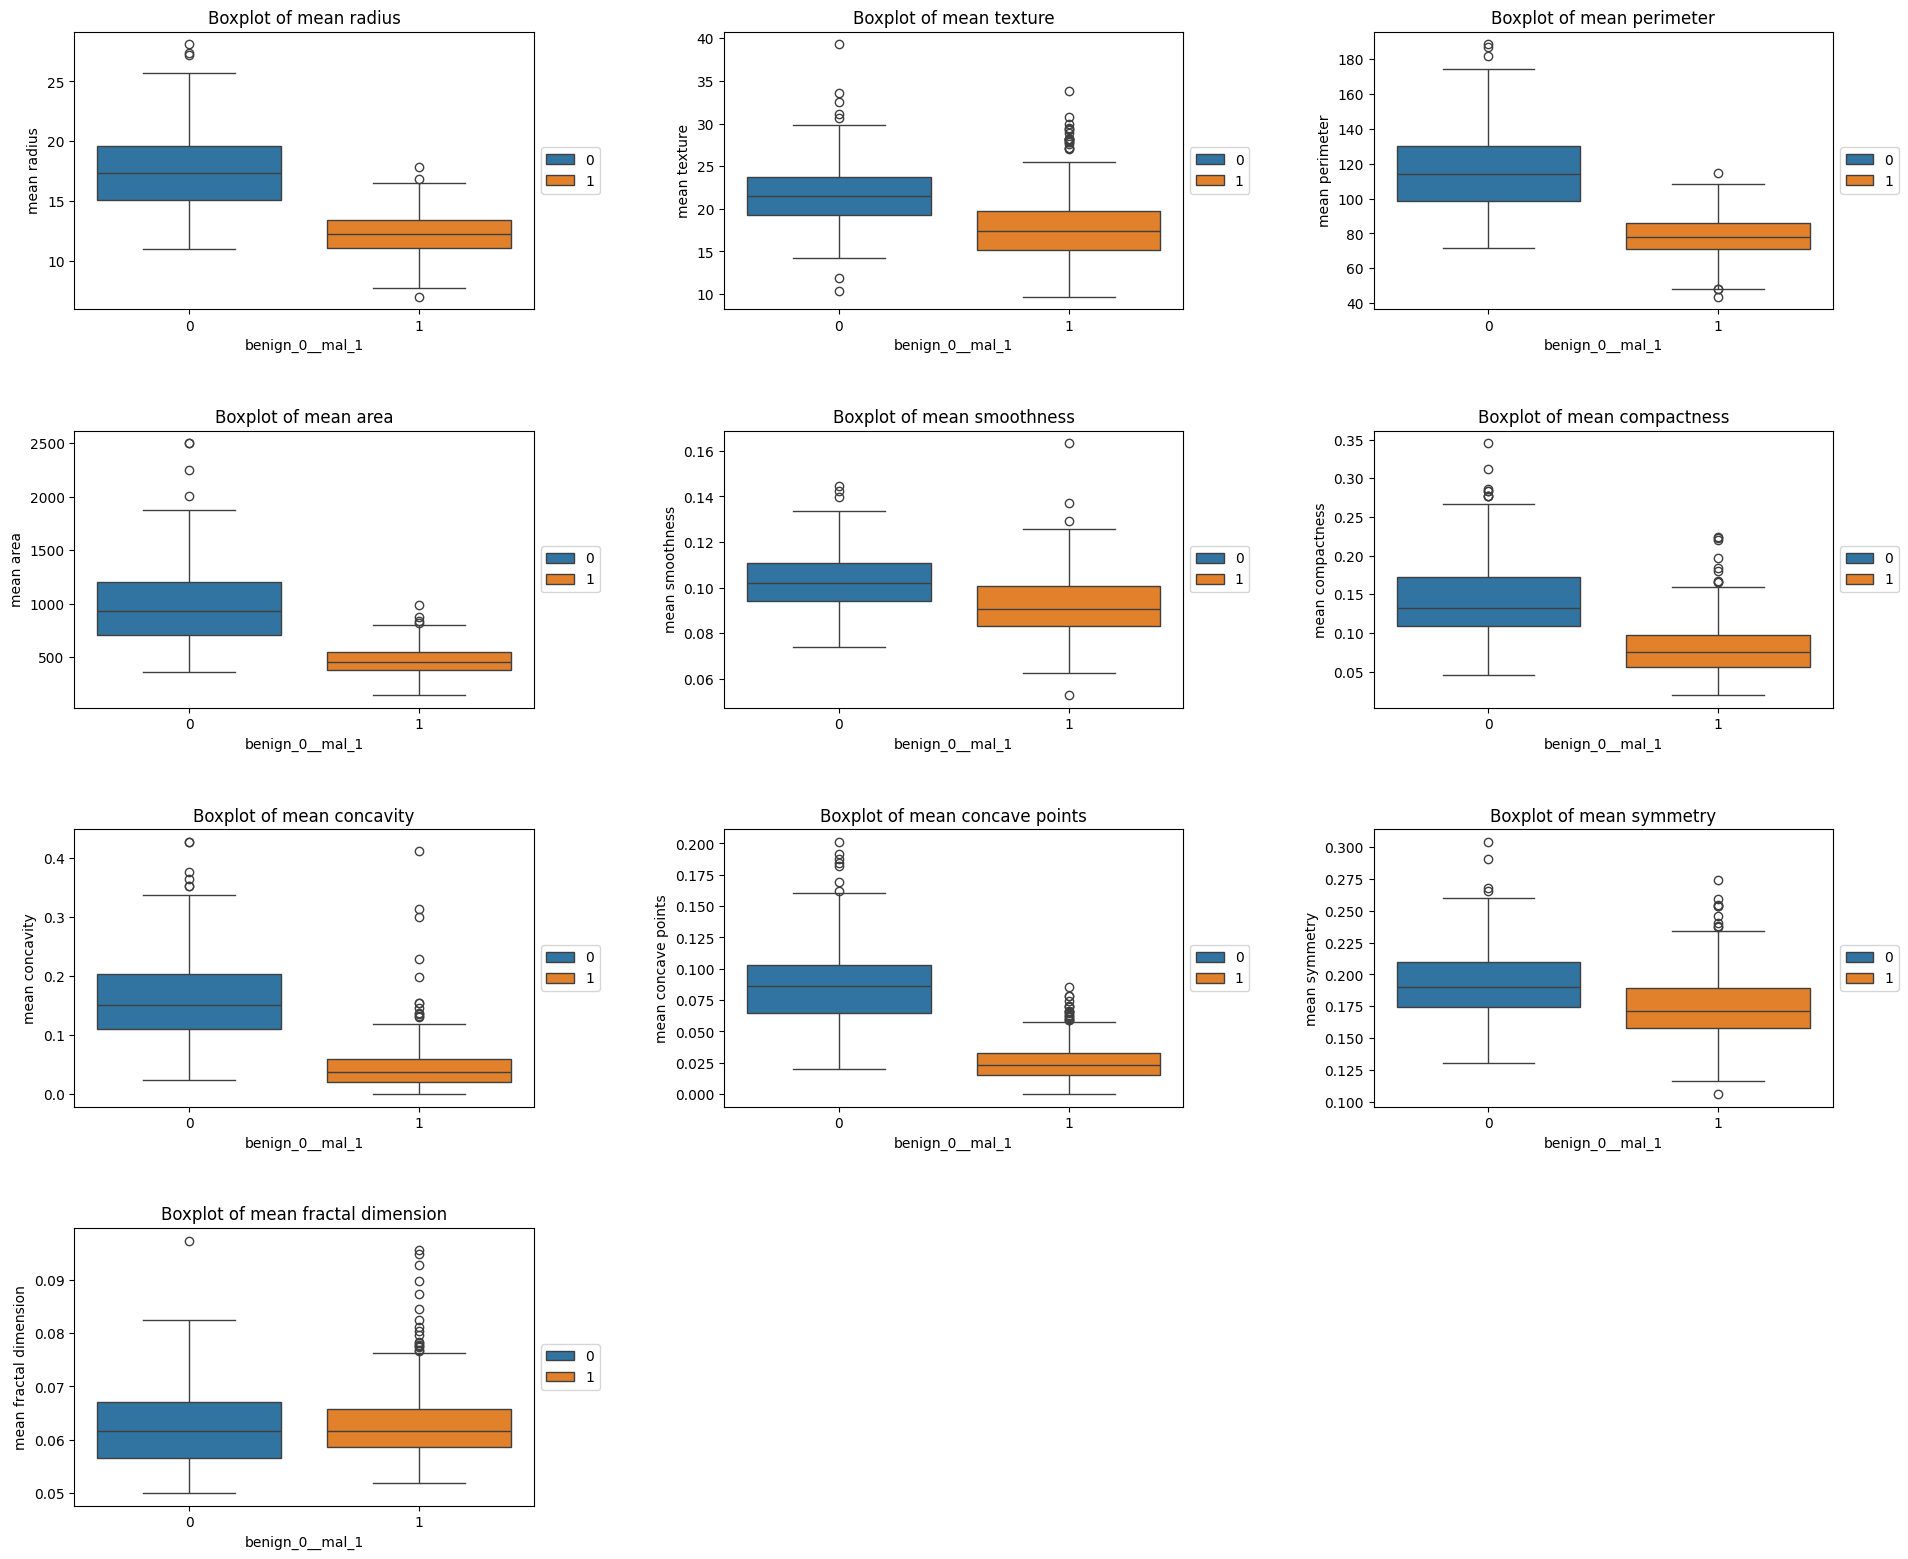

In [ ]:
plt.figure(figsize=(20, 40))
for i, column in enumerate(df_cancer_mean.columns[:-1], 1):
    plt.subplot(10, 3, i)
    sns.boxplot(x="benign_0__mal_1", y=column, data=df_cancer_mean, hue ='benign_0__mal_1')
    plt.title(f"Boxplot of {column}")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout(pad=4.0)
plt.show()

##Análise do *Error* dos dados

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 37.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 49.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 52.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 6.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 31.7% of the points cannot be place

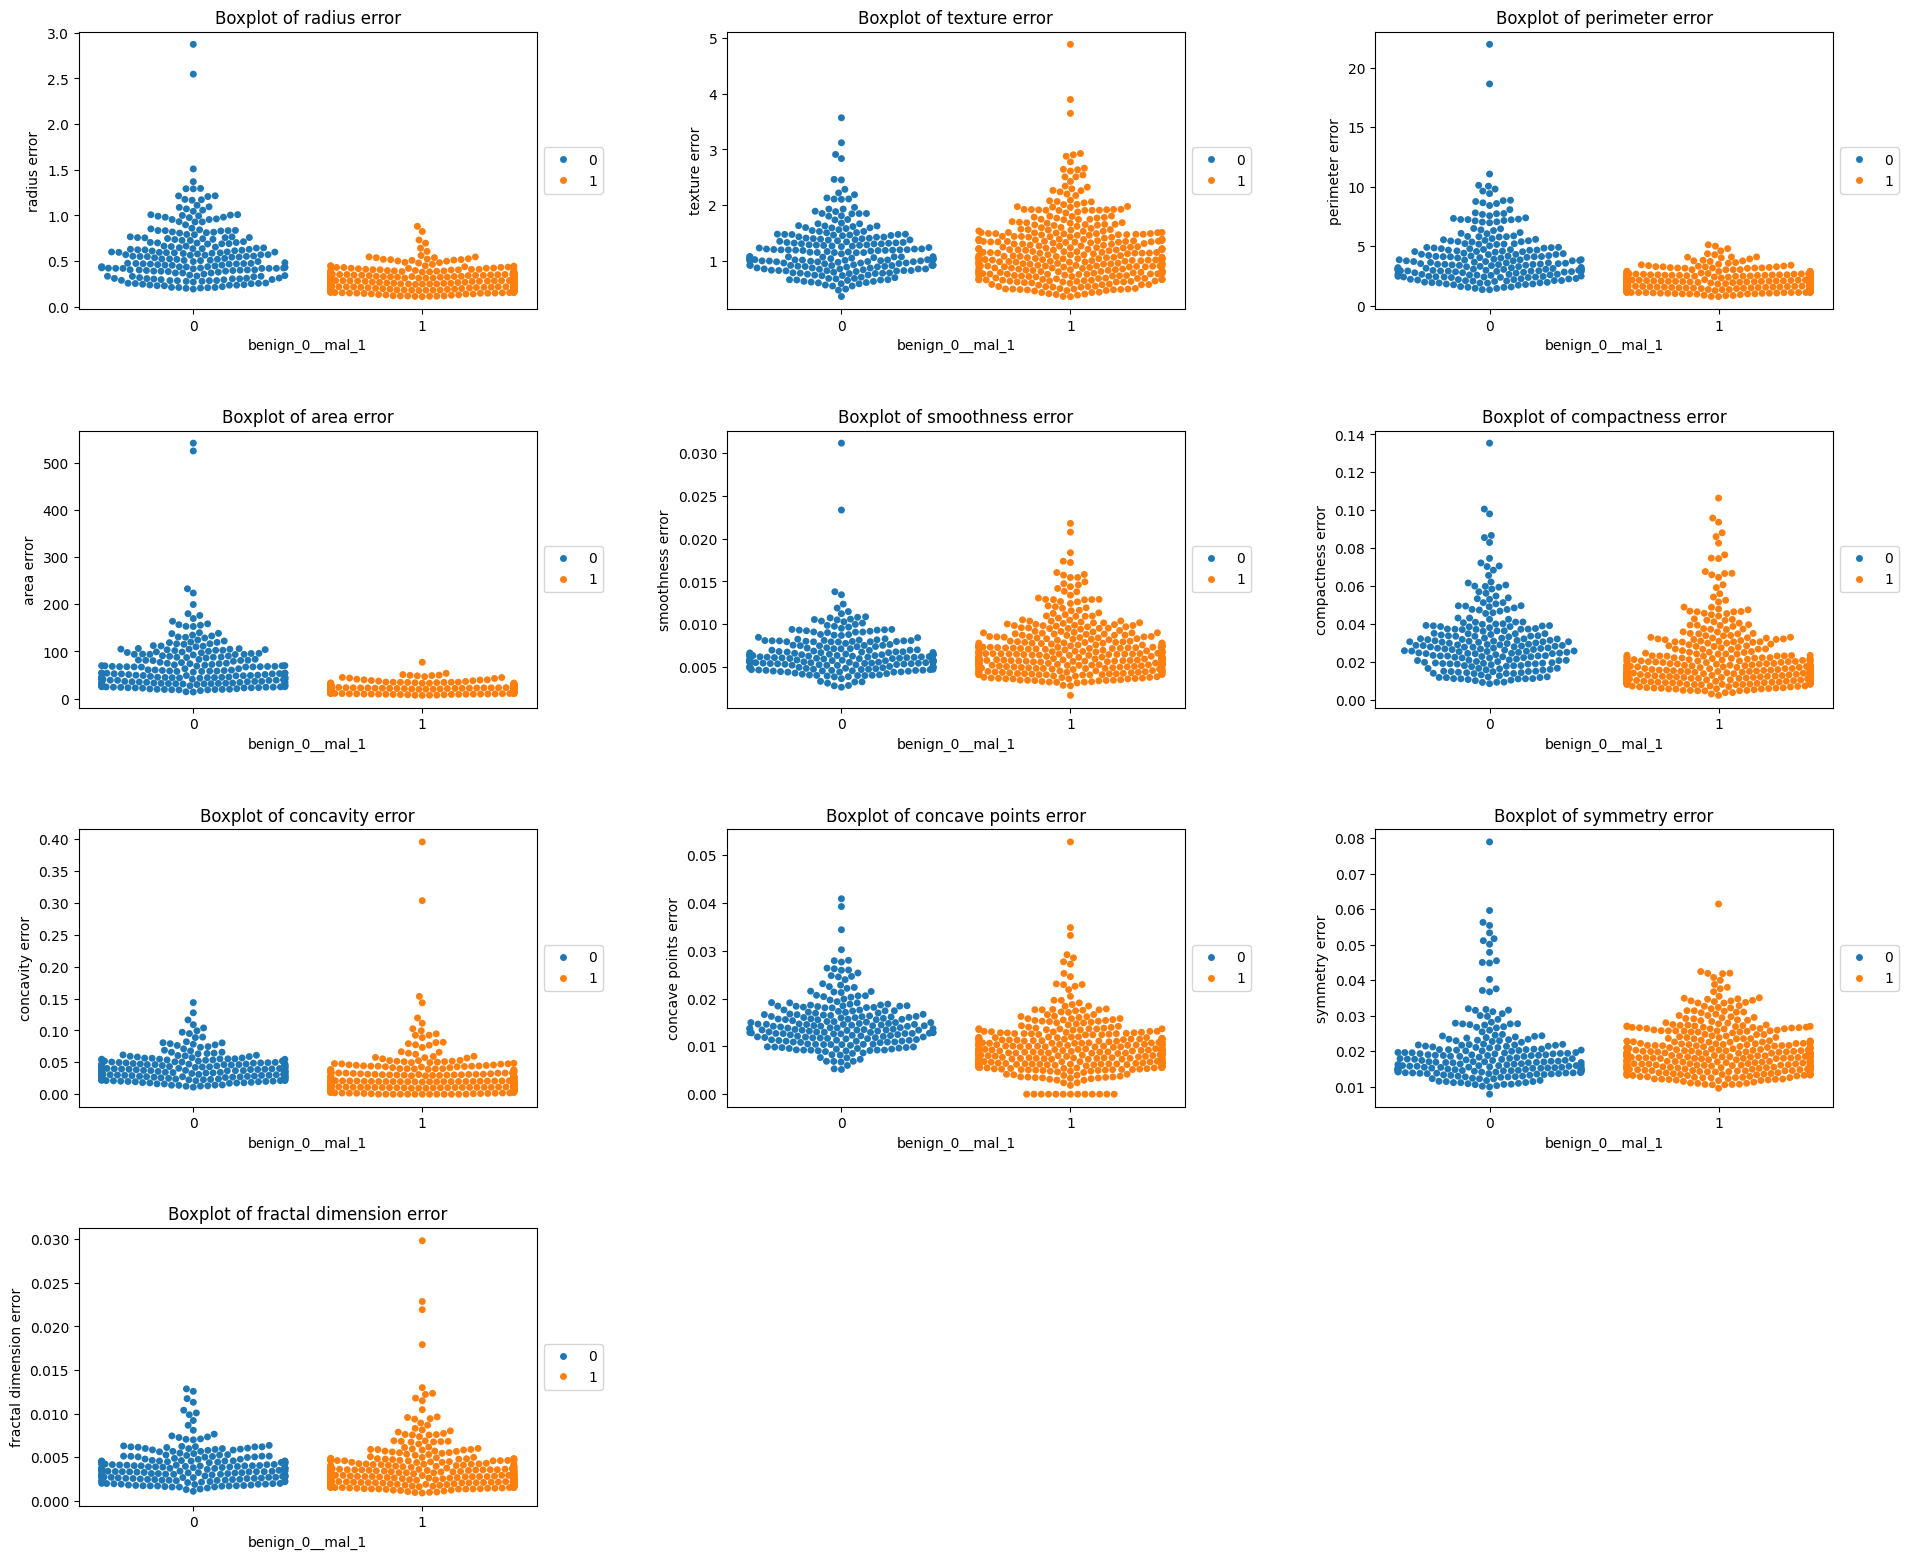

In [ ]:
plt.figure(figsize=(20,40))
for i, column in enumerate(df_cancer_error.columns[:-1], 1):
    plt.subplot(10, 3, i)
    sns.swarmplot(x="benign_0__mal_1", y=column, data=df_cancer_error, hue ='benign_0__mal_1')
    plt.title(f"Boxplot of {column}")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Mova a legenda para fora da figura
    plt.tight_layout(pad=4.0)
plt.show()

##Análise *Worst* dos dados

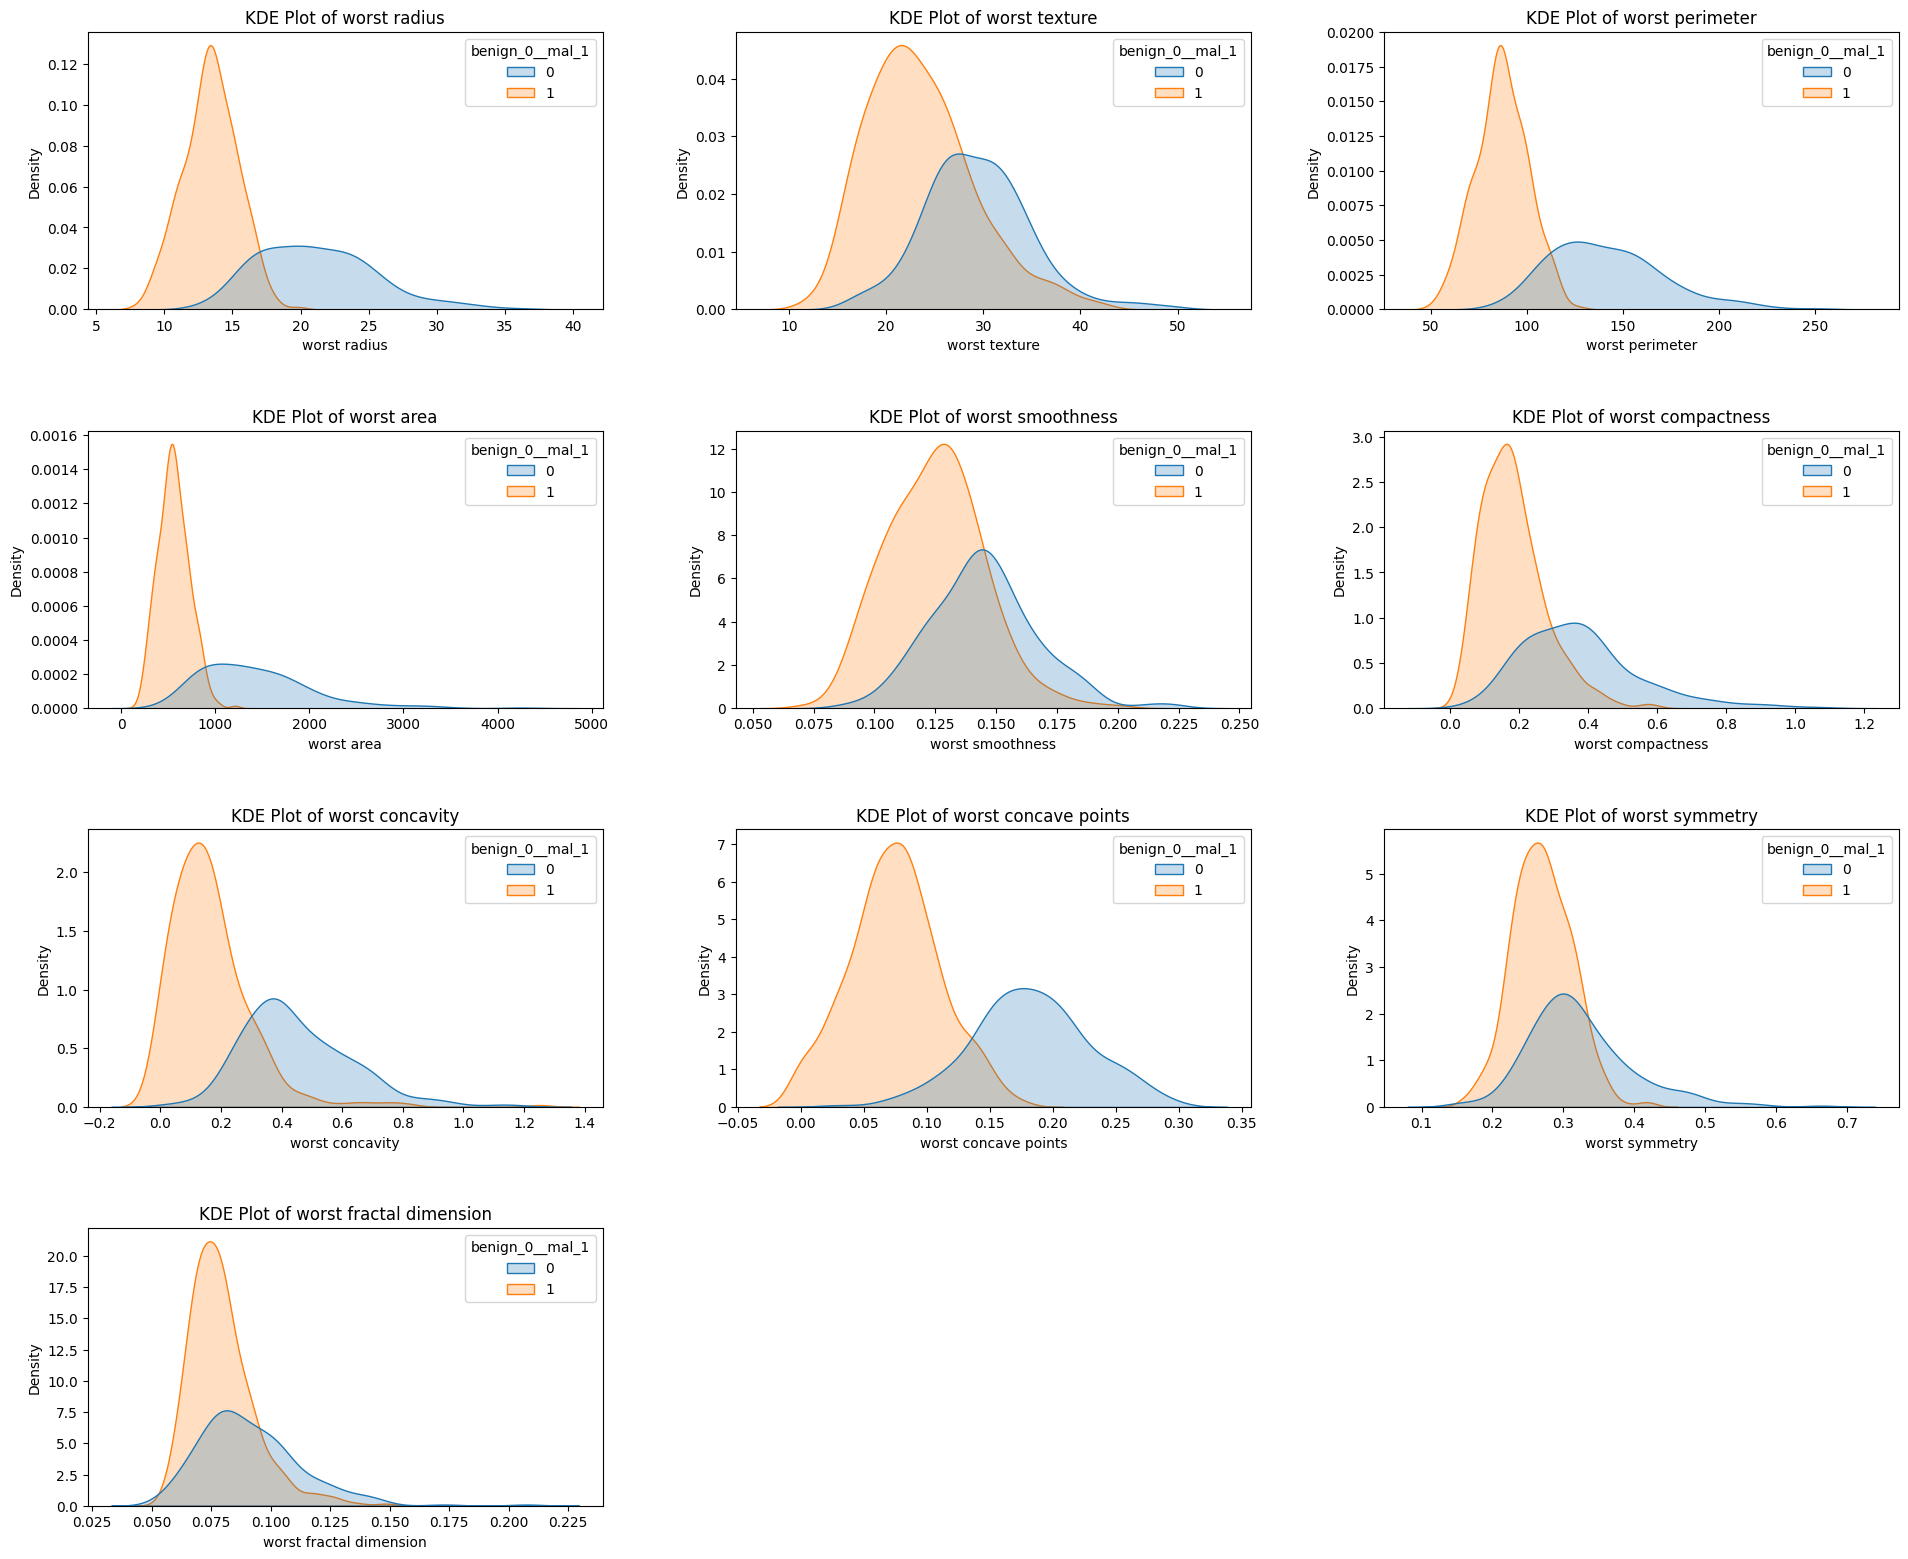

In [ ]:
plt.figure(figsize=(20,40))
for i, column in enumerate(df_cancer_worst.columns[:-1], 1):
    plt.subplot(10,3,i)
    sns.kdeplot(x=column, data=df_cancer_worst, hue="benign_0__mal_1", fill=True)
    plt.title(f"KDE Plot of {column}") # Changed title to reflect plot type
    plt.tight_layout(pad=4.0)
plt.show()

###Análise de correlação do *Mean*

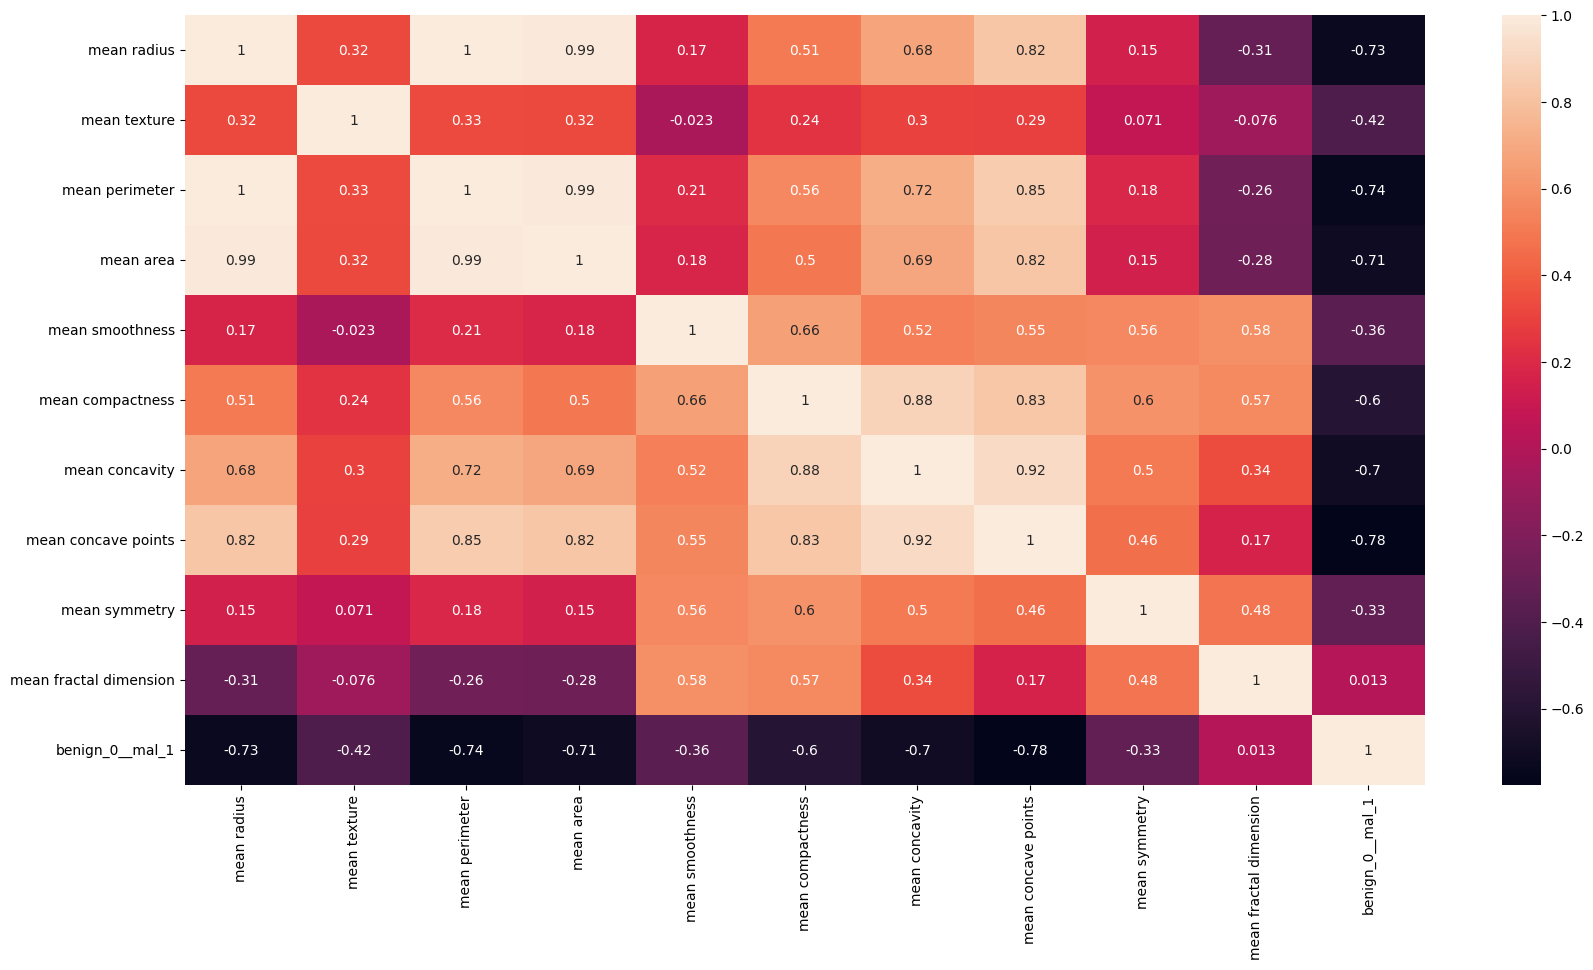

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(df_cancer_mean.corr(), annot=True)
plt.show()

###Análise de correlação dos *Error* dos dados

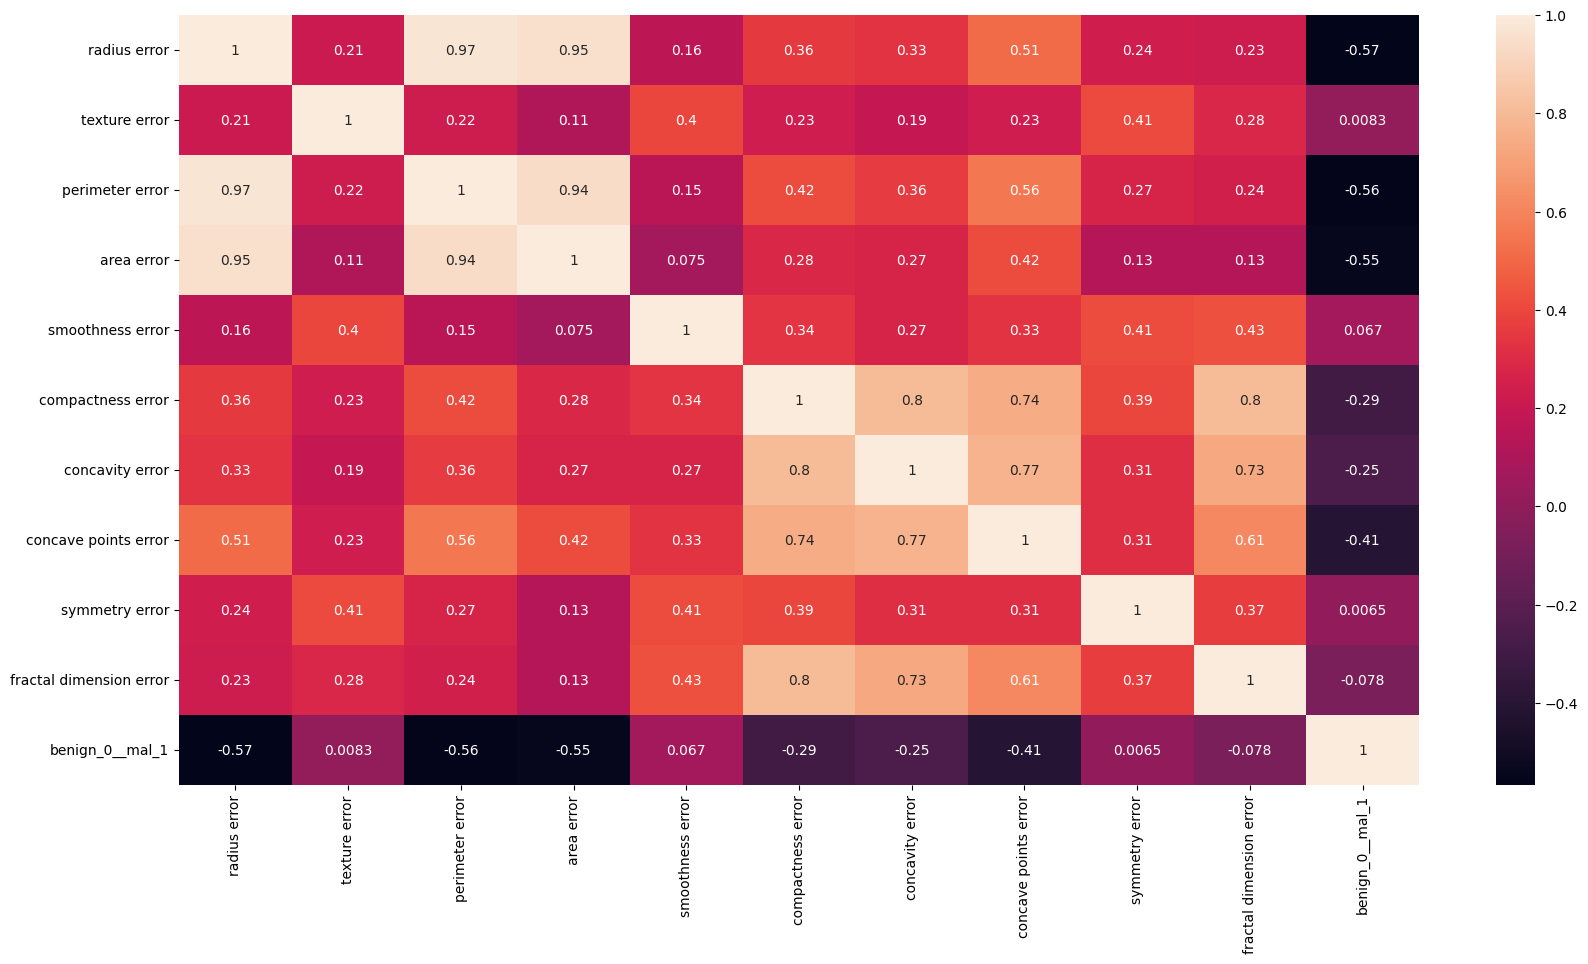

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(df_cancer_error.corr(), annot=True)
plt.show()

###Análise de correlação dos *Worst* dos dados

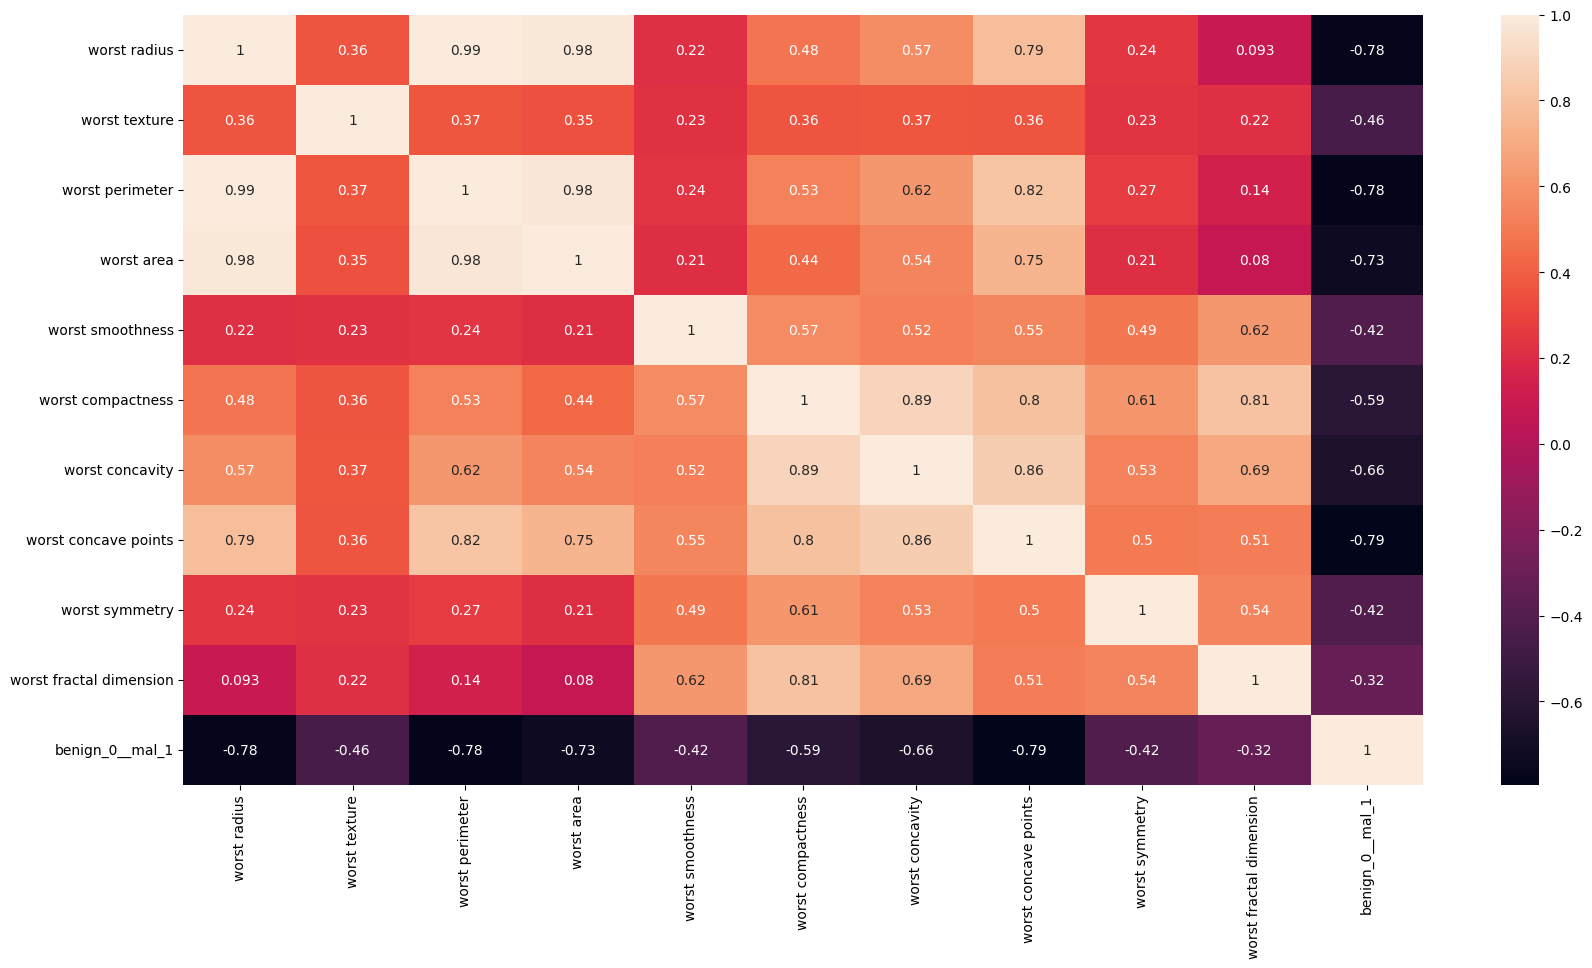

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(df_cancer_worst.corr(), annot=True)
plt.show()

<Axes: >

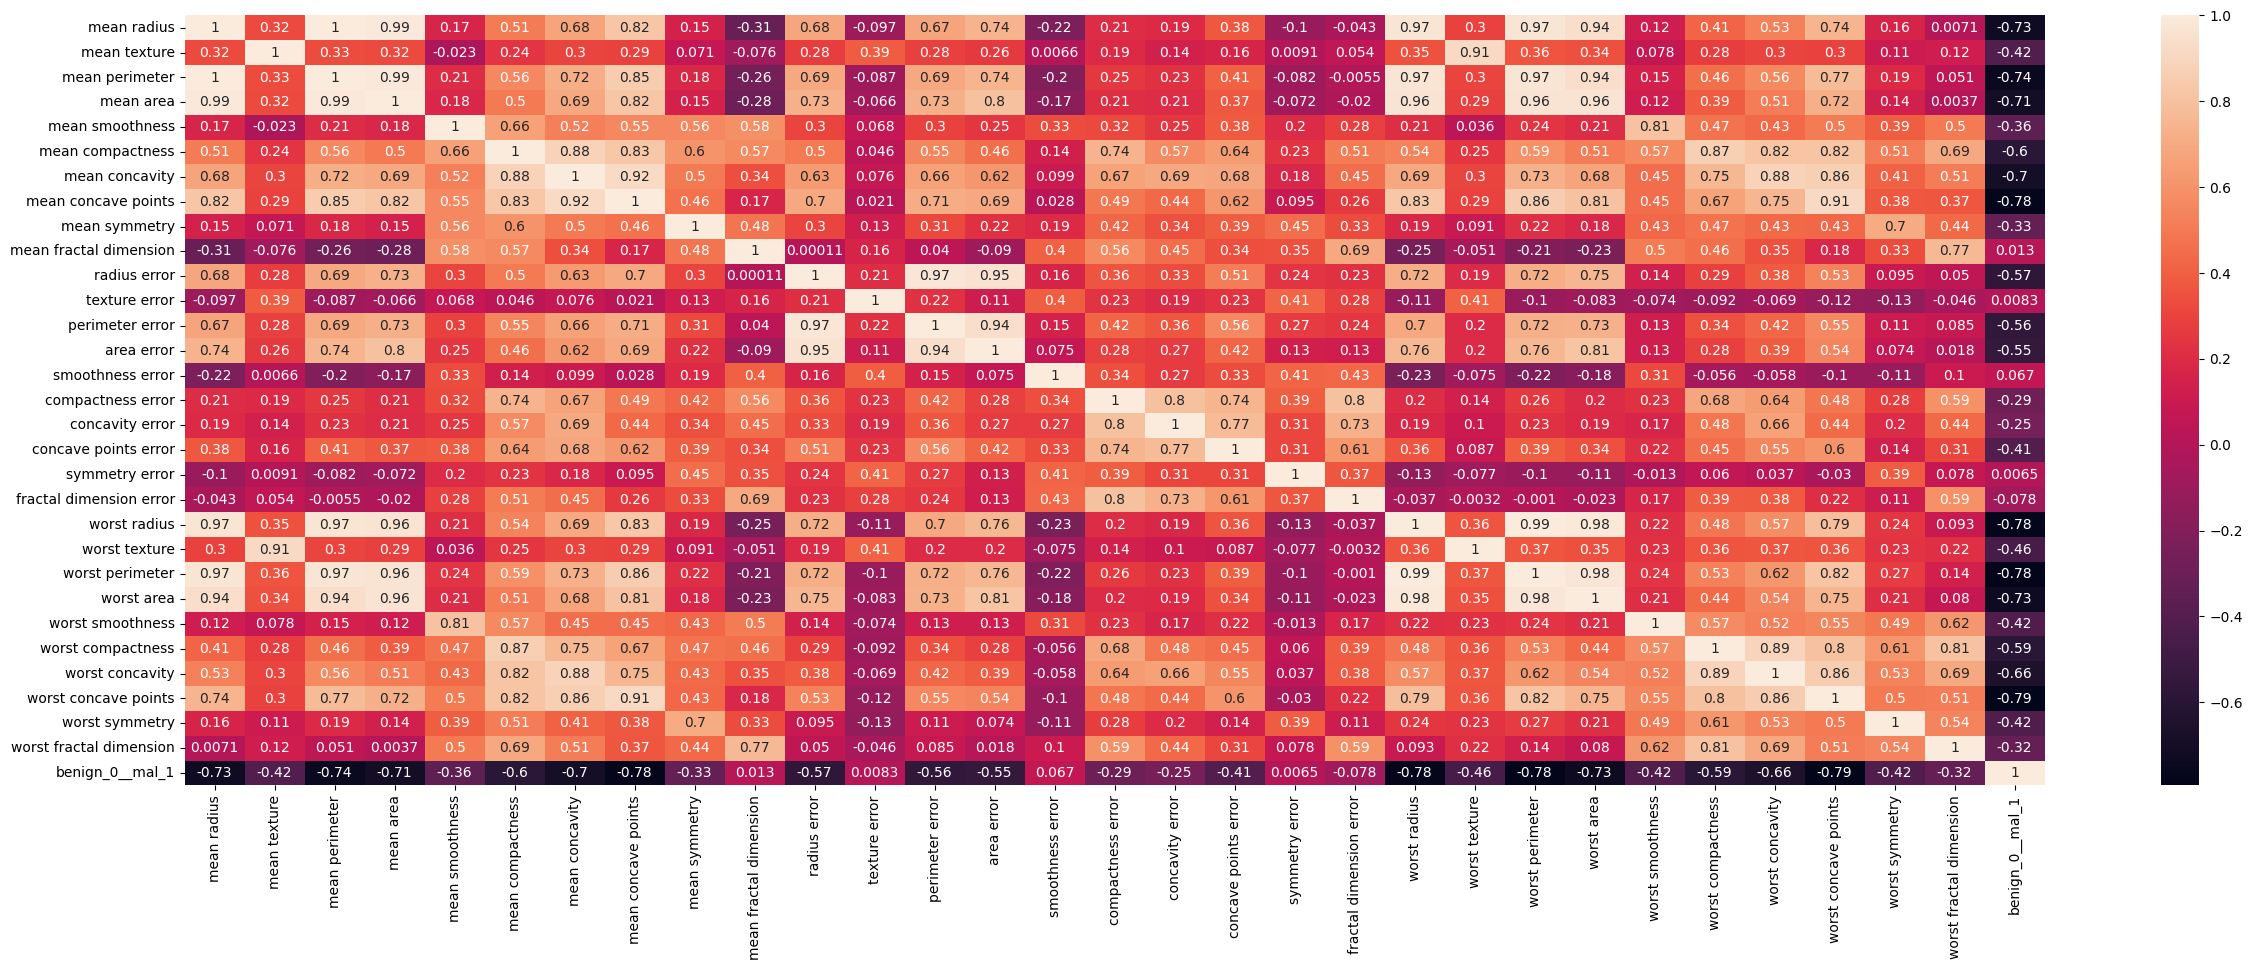

In [ ]:
plt.figure(figsize=(30,10))
sns.heatmap(df_cancer.corr(), annot=True)

# Pre-Processamento dos Dados

In [ ]:
X = df_cancer.drop('benign_0__mal_1', axis=1)
Y = df_cancer['benign_0__mal_1']


Separação dos dados em treino e teste

In [ ]:
# Divisão da base em treino e teste (70% para treinamento e 30% para teste)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42,stratify=Y)

Normalização dos dados de treino e teste

In [ ]:
#Feature Scalling, Padronização z-score
#Padranizar
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


Visualização da distribuição do diagnóstico de treino

<ipython-input-21-85cadb678dba>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.countplot(y =y_train, palette ='cubehelix', edgecolor ='Black')


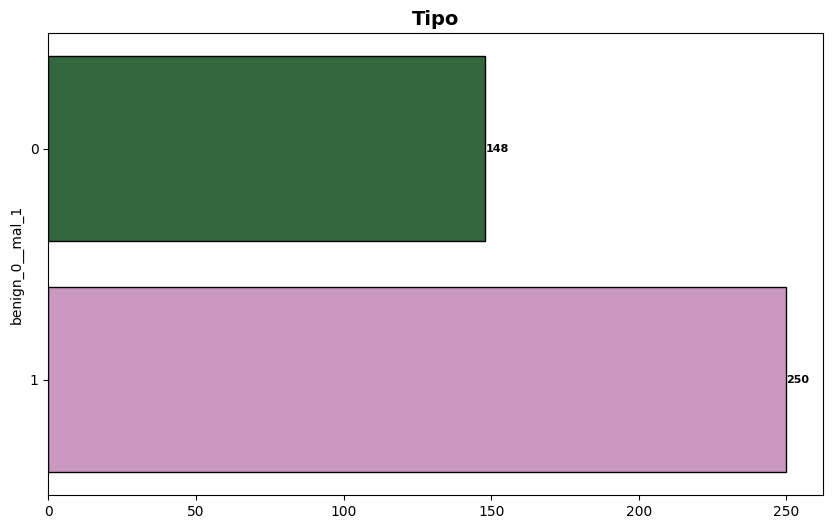

In [ ]:
fig, ax =plt.subplots(figsize=(10, 6))
ax=sns.countplot(y =y_train, palette ='cubehelix', edgecolor ='Black')
for bars in ax.containers:
    ax.bar_label(bars, fontsize =8, fontweight ='bold')
ax.set_xlabel("")
ax.set_title('Tipo', fontsize = 14, fontweight = 'bold', color = 'black')
fig.show()
plt.show()

Visualização da distribuição do diagnóstico de teste

<ipython-input-22-70e854809869>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.countplot(y=y_test, palette ='cubehelix', edgecolor ='Black')


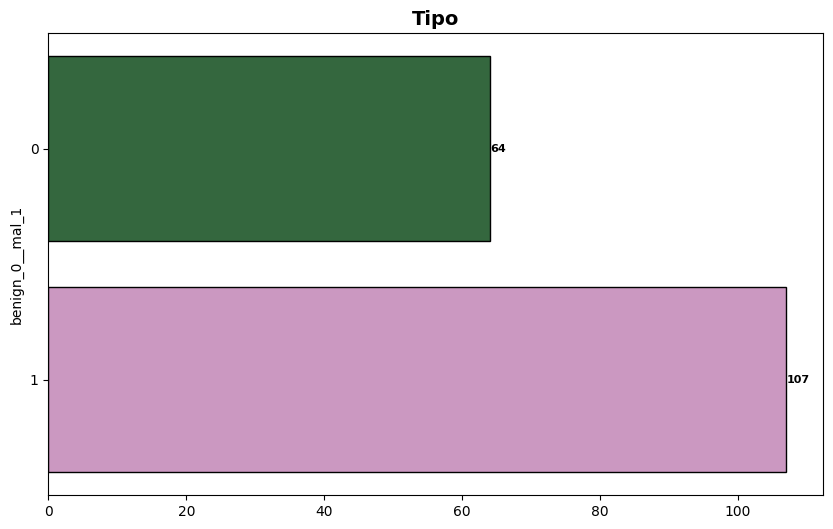

In [ ]:
fig, ax =plt.subplots(figsize=(10, 6))
ax=sns.countplot(y=y_test, palette ='cubehelix', edgecolor ='Black')
for bars in ax.containers:
    ax.bar_label(bars, fontsize =8, fontweight ='bold')
ax.set_xlabel("")
ax.set_title('Tipo', fontsize = 14, fontweight = 'bold', color = 'black')
fig.show()
plt.show()

##Implementação do modelo LGBMClassifier

In [ ]:
lgbm = LGBMClassifier(random_state = 42, n_jobs = -1, verbosity = -1)
lgbm.fit(X_train, y_train)

LGBMClassifier(n_jobs=-1, random_state=42, verbosity=-1)

Previsão do modelo

In [ ]:
y_pred = lgbm.predict(X_test)

Accuracy do modelo apresenta uma eficácia de 96% de acerto

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9649122807017544

Na análise abaixo *precision* e *recall* são pontos fundamentais para entender o desempenho do modelo

Para o valor *0* o recall foi de 92% ou seja o modelo identificou 92% dos dados que tem valor igual a *0* e teve precisão dessa identificação 98%

Para o valor *1* o recall foi de 99% ou seja o modelo identificou 99% dos dados que tem valor igual a *0* e teve precisão dessa identificação 95%

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95        64
           1       0.95      0.99      0.97       107

    accuracy                           0.96       171
   macro avg       0.97      0.96      0.96       171
weighted avg       0.97      0.96      0.96       171



Na matriz de confusão o modelo as estatística acima são muito bem represetada, percebe-se que o modelo errou em cinco ocasiões para prever a classe *0* e e errou apenas uma ocasião a classe *1*

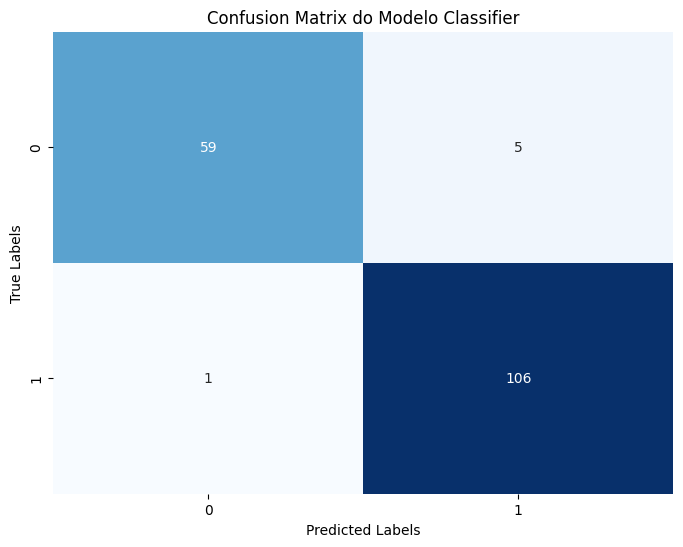

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix do Modelo Classifier')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#Análise ROC

 é uma medida de desempenho para os problemas de classificação em várias configurações de limite. ROC é uma curva de probabilidade e AUC representa o grau ou medida de separabilidade. Diz o quanto o modelo é capaz de distinguir entre as classes.

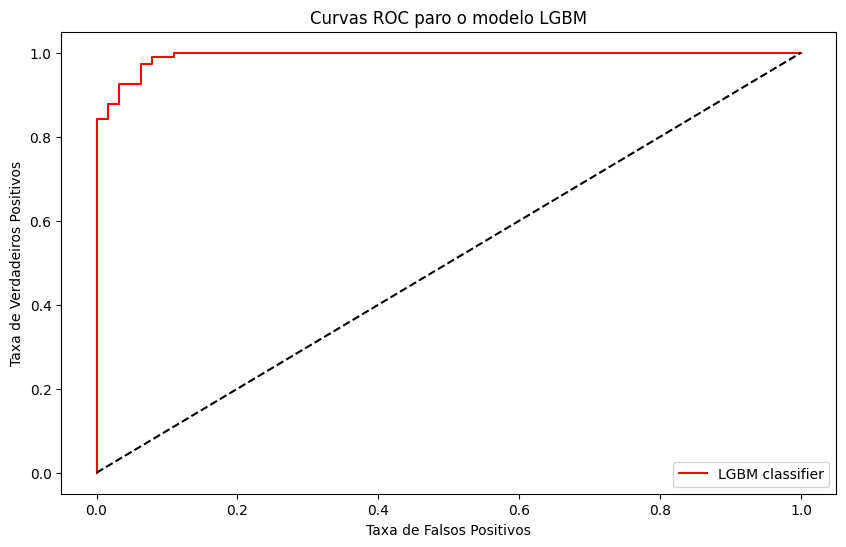

Decision Tree AUC: 0.9926


In [ ]:
# Calcula as curvas ROC e AUC para modelo
lgbm_fpr, lgbm_tpr, _ = roc_curve(y_test, lgbm.predict_proba(X_test)[:, 1])


# Cria uma figura para as curvas ROC
fig, ax = plt.subplots(figsize=(10, 6))

# Plota as curvas ROC para  modelo
RocCurveDisplay(fpr=lgbm_fpr, tpr=lgbm_tpr).plot(ax=ax, label='LGBM classifier', color='red') # Passa 'label' para o método plot


# Adiciona uma linha diagonal
ax.plot([0, 1], [0, 1], color='black', linestyle='--')

# Adiciona rótulos e título
ax.set_xlabel('Taxa de Falsos Positivos')
ax.set_ylabel('Taxa de Verdadeiros Positivos')
ax.set_title('Curvas ROC paro o modelo LGBM')
ax.legend()

# Mostra o gráfico
plt.show()

# Calcula a AUC para cada modelo
lgbm_auc = auc(lgbm_fpr, lgbm_tpr)


# Imprime os valores de AUC
print(f'Decision Tree AUC: {lgbm_auc:.4f}')


Portanto, o modelo conseguir destinguir 99,26% das classes

In [ ]:
metrics = {
    "Model": ["LGBM classifier"],
    "Accuracy": [accuracy],
    "Precision 0": [precision_score(y_test, y_pred, pos_label=0)],
    "Precision 1": [precision_score(y_test, y_pred, pos_label=1)],
    "Score Train": [lgbm.score(X_train, y_train)],
    "Score Test": [lgbm.score(X_test, y_test)],
    "ROC AUC": [lgbm_auc]
}

# Create a pandas DataFrame
df_metrics = pd.DataFrame(metrics)




Resultado do modelo

In [ ]:
df_metrics.head()

,Model,Accuracy,Precision 0,Precision 1,Score Train,Score Test,ROC AUC
0,LGBM classifier,0.964912,0.983333,0.954955,1.0,0.964912,0.992553


#Conclusão

Esse projeto consta aplicar o algoritmo O LightGBM (Light Gradient Boosting Machine) é um modelo de aprendizado de máquina baseado em técnicas de boosting, mais especificamente em gradient boosting, o modelo reside em sua capacidade de combinar eficiência e precisão ao utilizar técnicas avançadas de construção de árvores e otimização de gradient boosting.  esse dataframe foi retirado da plataforma Kaggle [Cancer classification](https://www.kaggle.com/datasets/sahilnbajaj/cancer-classification)
